<a href="https://colab.research.google.com/github/BenjaminGuerreroLewin/landslide_inventory/blob/main/RandomForest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Mount Google Drive

In [1]:
#attach to Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Import Packages

In [ ]:
from osgeo import gdal
import os
import glob
import numpy as np
import re
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.metrics import (accuracy_score, confusion_matrix, classification_report)

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE

from scipy.ndimage.filters import generic_filter
from scipy.stats import mode

### Preparing the dataset: Opening the images


In [10]:
!git clone https://github.com/BenjaminGuerreroLewin/open-geo-tutorial /content/drive/MyDrive/open-geo-tutorial 


Cloning into '/content/drive/MyDrive/open-geo-tutorial'...
remote: Enumerating objects: 387, done.
remote: Counting objects: 100% (14/14), done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 387 (delta 8), reused 8 (delta 8), pack-reused 373
Receiving objects: 100% (387/387), 28.50 MiB | 12.72 MiB/s, done.
Resolving deltas: 100% (233/233), done.


(3204, 4312, 1)
(3182, 4099)


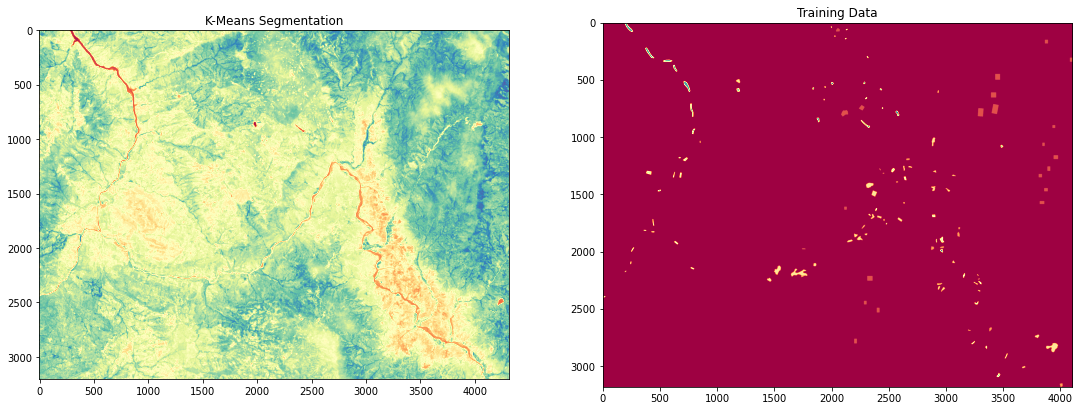

In [39]:
# Import Python 3's print function and division
from __future__ import print_function, division

# Import GDAL, NumPy, and matplotlib
from osgeo import gdal, gdal_array
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Tell GDAL to throw Python exceptions, and register all drivers
gdal.UseExceptions()
gdal.AllRegister()  

# Read in our image and ROI image
img_ds = gdal.Open('/content/drive/MyDrive/EnvDatSci_FinalProject/NDVI_chicamocha.tif', gdal.GA_ReadOnly)
roi_ds = gdal.Open('/content/drive/MyDrive/EnvDatSci_FinalProject/training_land.tif', gdal.GA_ReadOnly)



img = np.zeros((img_ds.RasterYSize, img_ds.RasterXSize, img_ds.RasterCount),
               gdal_array.GDALTypeCodeToNumericTypeCode(img_ds.GetRasterBand(1).DataType))
img[:, :, 0] = img_ds.GetRasterBand(1).ReadAsArray()

roi = roi_ds.GetRasterBand(1).ReadAsArray().astype(np.uint8)

print(img.shape)
print(roi.shape)

# Display them
plt.subplot(121)
plt.imshow(img[:, :, 0], cmap=plt.cm.Spectral)
plt.title('K-Means Segmentation')

plt.subplot(122)
plt.imshow(roi, cmap=plt.cm.Spectral)
plt.title('Training Data')

fig = plt.gcf()
fig.set_size_inches(18.5, 18.5)

#plt.show()

4099
(3182, 4099, 1)
(3182, 4099)


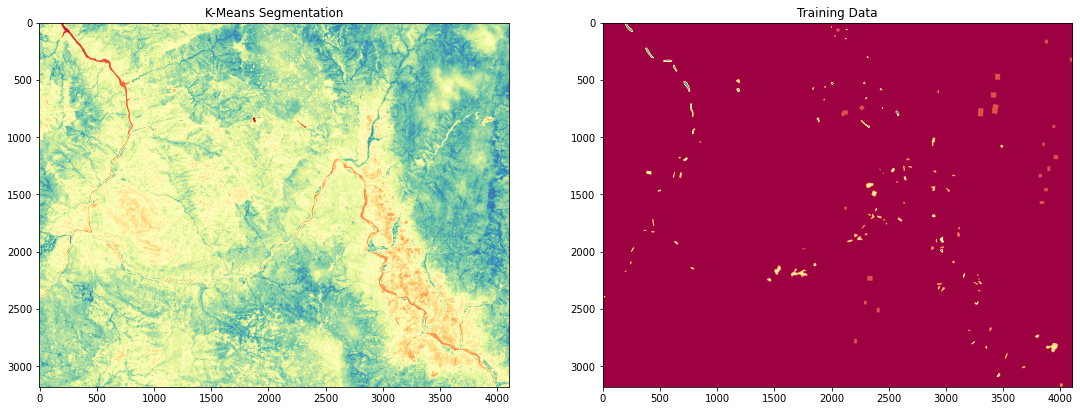

In [52]:
# Read in our image and ROI image
img_ds = gdal.Open('/content/drive/MyDrive/EnvDatSci_FinalProject/NDVI_chicamocha.tif', gdal.GA_ReadOnly)
roi_ds = gdal.Open('/content/drive/MyDrive/EnvDatSci_FinalProject/training_land.tif', gdal.GA_ReadOnly)

gt = roi_ds.GetGeoTransform()
lt = img_ds.GetGeoTransform()

SmlMaxX = gt[0] + (gt[1] * roi_ds.RasterXSize)
SmlMinY = gt[3] + (gt[5] * roi_ds.RasterYSize)
Xoff = int((gt[0] - lt[0])/lt[1]) # cols to skip
Yoff = int((gt[3] - lt[3])/lt[5]) # rows to skip
Cols = int((SmlMaxX - gt[0])/lt[1])
Rows = int((SmlMinY - gt[3])/lt[5])

band = img_ds.GetRasterBand(1)
data = img_ds.ReadAsArray(Xoff,Yoff,Cols,Rows) # read the larger raster

img = np.zeros((data.shape[0], data.shape[1], 1),
               gdal_array.GDALTypeCodeToNumericTypeCode(img_ds.GetRasterBand(1).DataType))
img[:, :, 0] = data

roi = roi_ds.GetRasterBand(1).ReadAsArray().astype(np.uint8)

print(img.shape)
print(roi.shape)

# Display them
plt.subplot(121)
plt.imshow(img[:, :, 0], cmap=plt.cm.Spectral)
plt.title('K-Means Segmentation')

plt.subplot(122)
plt.imshow(roi, cmap=plt.cm.Spectral)
plt.title('Training Data')

fig = plt.gcf()
fig.set_size_inches(18.5, 18.5)


###Pairing Y with X
Now that we have the image we want to classify (our X feature inputs), and the ROI with the land cover labels (our Y labeled data), we need to pair them up in NumPy arrays so we may feed them to Random Forest:

In [54]:
# Find how many non-zero entries we have -- i.e. how many training data samples?
n_samples = (roi > 0).sum()
print('We have {n} samples'.format(n=n_samples))

# What are our classification labels?
labels = np.unique(roi[roi > 0])
print('The training data include {n} classes: {classes}'.format(n=labels.size, 
                                                                classes=labels))
# We will need a "X" matrix containing our features, and a "y" array containing our labels
#     These will have n_samples rows
#     In other languages we would need to allocate these and them loop to fill them, but NumPy can be faster

X = img[roi > 0, :]  # include 8th band, which is Fmask, for now
y = roi[roi > 0]

print('Our X matrix is sized: {sz}'.format(sz=X.shape))
print('Our y array is sized: {sz}'.format(sz=y.shape))


We have 81978 samples
The training data include 7 classes: [1 2 3 4 5 6 7]
Our X matrix is sized: (81978, 1)
Our y array is sized: (81978,)


### Training the Random Forest
Now that we have our X matrix of feature inputs (the NDVI band) and our y array (the labels), we can train our model.

In [55]:
from sklearn.ensemble import RandomForestClassifier

# Initialize our model with 500 trees
rf = RandomForestClassifier(n_estimators=500, oob_score=True)

# Fit our model to training data
rf = rf.fit(X, y)

### Random Forest diagnostics
With our Random Forest model fit, we can check out the "Out-of-Bag" (OOB) prediction score:

In [ ]:
print('Our OOB prediction of accuracy is: {oob}%'.format(oob=rf.oob_score_ * 100))


To help us get an idea of which spectral bands were important, we can look at the feature importance scores:

In [ ]:
for b, imp in zip(1, rf.feature_importances_):
    print('Band {b} importance: {imp}'.format(b=b, imp=imp))

With the largest weights, it looks like the SWIR1 and the Green bands were the most useful to us. Not surprising, the thermal band is not very useful because there isn't much delineation of land cover type with temperature if you only look with a very small area not influenced by Urban Heat Island.

Let's look at a crosstabulation to see the class confusion. To do so, we will import the Pandas library for some help: